# Capstone 2: *National Transit Database*
## *Preprocessing and Training*
***

## 3.1 Table of Contents<a id='3.1_Contents'></a>
* [3 Preprocessing and Training](#3_Preprocessing_and_Training)
  * [3.1 Table of Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Importing the Dependencies](#3.3_Importing_the_Dependencies)
  * [3.4 Importing the Data](#3.4_Importing_the_Data)
  * [3.5 Defining Safety](#3.5_Defining_Safety)
      * [3.5.1 'Total Events' Column](#3.5.1_Total_Events_Column)
      * [3.5.2 Drop Columns Captured by 'Total Events'](#3.5.2_Drop_Columns_Captured_by_Total_Events)
      * [3.5.3 Dropping 'Primary UZA Code', 'Vehicles', and 'Vehicle Revenue Hours'](#3.5.3_Dropping_Primary_UZA_Code_Vehicles_and_Vehicle_Revenue_Hours)
      * [3.5.4 Add 'Safety Ratio' Column](#3.5.4_Add_Safety_Ratio_Column)
      * [3.5.5 Drop Columns Included in 'Safety Ratio'](#3.5.5_Drop_Columns_Included_in_Safety_Ratio)
      * [3.5.6 Aggregate Data](#3.5.6_Aggregate_Data)
      * [3.5.7 Dropping the Location Columns](#3.5.7_Dropping_the_Location_Columns)
  * [3.6 Encoding the Categorical Features](#3.6_Encoding_the_Categorical_Features)
  * [3.7 Exploring the Data](#3.7_Exploring_the_Data)
  * [3.8 Model Trials](#3.8_Model_Trials)
      * [3.8.1 Transforming the Target](#3.8.1_Transforming_the_Target)
      * [3.8.2 Train/Test Split](#3.8.2_Train_Test_Split)
      * [3.8.3 Linear Regression](#3.8.3_Linear_Regression)
      * [3.8.4 Random Forest](#3.8.4_Random_Forest)
      * [3.8.5 KNN](#3.8.5_KNN)
      * [3.8.6 Comparing the Models' Performance](#3.8.6_Comparing_the_Models_Performance)
  * [3.9 Save the Data](#3.9_Save_the_Data)
  * [3.10 Summary](#3.10_Summary)

## 3.2 Introduction
<a id='3.2_Introduction'></a>

In the preceeding notebook, I refined the dataframes and began to explore the relationships between the variables.  In this notebook, I will further refine the data so only clear, valuable, numeric columns are remaining for the independent variables and so there is a single, clear, and distinct value for the dependent variable.  I will then split the data in train/test sets and evaluate the performance of several time-independant regression models.

## 3.3 Importing the Dependencies
<a id='3.3_Importing_the_Dependencies'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats

pd.set_option('display.max_rows', 70)

## 3.4 Importing the Data
<a id='3.4_Importing_the_Data'></a>

In [2]:
National_data = pd.read_csv("reduced_data.csv")
Nashville_data = pd.read_csv("Nashville_data.csv")

In [3]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   5 DIgit NTD ID                         129752 non-null  int64  
 1   Agency                                 129752 non-null  object 
 2   Organization Type                      129752 non-null  object 
 3   Mode                                   129752 non-null  object 
 4   Type of Service                        129752 non-null  object 
 5   Rail (Y/N)                             129752 non-null  bool   
 6   Primary UZA Code                       129752 non-null  float64
 7   Primary UZA Name                       129752 non-null  object 
 8   Primary UZA Sq Miles                   129752 non-null  float64
 9   Primary UZA Population                 129752 non-null  float64
 10  Service Area Sq Miles                  129752 non-null  

In [4]:
Nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5 DIgit NTD ID                         750 non-null    int64  
 1   Agency                                 750 non-null    object 
 2   Organization Type                      750 non-null    object 
 3   Mode                                   750 non-null    object 
 4   Type of Service                        750 non-null    object 
 5   Rail (Y/N)                             750 non-null    bool   
 6   Primary UZA Code                       750 non-null    float64
 7   Primary UZA Name                       750 non-null    object 
 8   Primary UZA Sq Miles                   750 non-null    float64
 9   Primary UZA Population                 750 non-null    float64
 10  Service Area Sq Miles                  750 non-null    float64
 11  Servic

## 3.5 Defining Safety
<a id='3.5_Defining_Safety'></a>

**Acronyms used in this notebook:**
* FTA: Federal Transit Administration
* MTA: Metropolitan Transit Authority
* NTD: National Transit Database
* SPM: Safety Performance Measure
* SPT: Safety Performance Target
* SR: Safety Ratio
* VRM: Vehicle Revenue Miles


The FTA requires public transportation providers to establish SPMs and use them to set annual SPTs.  These targets must depend only on data submittable to the NTD. Since my goal is to assit Nashville in its decision-making, I will use the SPMs of it's largest NTD reporter to guide my definition of safety.  The SPMs and SPTs for the MTA dba WeGo Public Transit can be found on page 8 of this document: [MTA Safety Performance Measures](https://www.wegotransit.com/file.aspx?DocumentId=102).  MTA's chosen SPMs match the example given by the FTA in their Safety Performance Targets Guide which can be found here: [FTA SPT Guide](https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-06/SPTs-Guide-v2-20210629.pdf).

In a future project, it would be great to incorporate System Reliability as part of the target definition of safety.  The data about failures (needed for System Reliability) is stored in separate annual Vehicle Maintenance xlsx files available through the NTD.

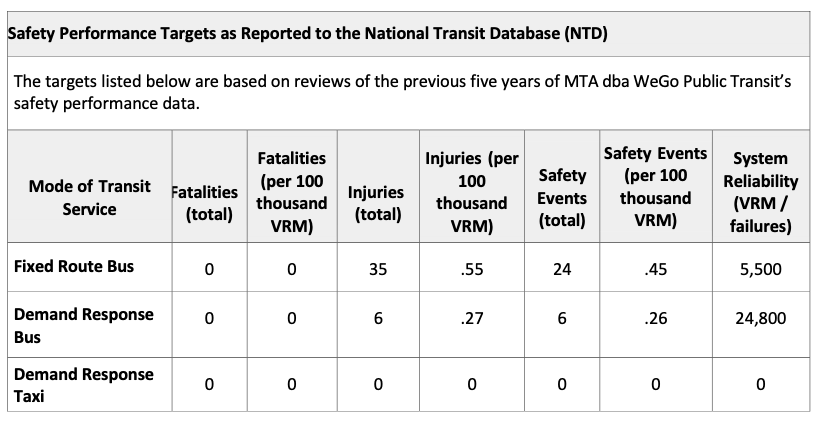

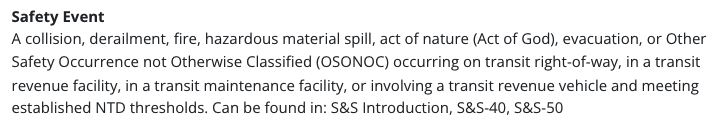

### 3.5.1 'Total Events' Column
<a id='3.5.1_Total_Events_Column'></a>
The NTD database does not have a column called 'Total Safety Events' so I will verify that the 'Toal Events' column is a total of all the events listed in the definition above from given in the [FTA Glossary](https://www.transit.dot.gov/ntd/national-transit-database-ntd-glossary).

In [5]:
#Check to see if 'Total Events" captures all data in columns 'Total Collisions', 'Total Derailments', 'Total Fires',
#'Total Security Events', and 'Total Events Not Otherwise Classified'

National_events = National_data.iloc[:, 18:24]
Nashville_events = Nashville_data.iloc[:, 18:24]
count5 = 0
count6 = 0

for i in National_events.index:
    if sum(National_events.iloc[i,[5]]) != sum(National_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)

for i in Nashville_events.index:
    if sum(Nashville_events.iloc[i,[5]]) != sum(Nashville_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)        

print('There are ',count5, "rows where 'Total Events' does not match the sum of the other National columns")
print('There are ',count6, "rows where 'Total Events' does not match the sum of the other Nashville columns")

There are  0 rows where 'Total Events' does not match the sum of the other National columns
There are  0 rows where 'Total Events' does not match the sum of the other Nashville columns


Since the 'Total Events' column is confirmed to be the total of the other columns, I can drop the other columns from both the National and Nashville dataframes.

### 3.5.2 Drop Columns Captured by 'Total Events'
<a id='3.5.2_Drop_Columns_Captured_by_Total_Events'></a>

In [6]:
National_data.shape

(129752, 26)

In [7]:
Nashville_data.shape

(750, 26)

In [8]:
National_data = National_data.drop(National_data.iloc[:, 18:23], axis=1)
Nashville_data = Nashville_data.drop(Nashville_data.iloc[:, 18:23], axis=1)


In [9]:
National_data.shape

(129752, 21)

In [10]:
Nashville_data.shape

(750, 21)

### 3.5.3 Dropping 'Primary UZA Code', 'Vehicles', and 'Vehicle Revenue Hours'
<a id='3.5.3_Dropping_Primary_UZA_Code_Vehicles_and_Vehicle_Revenue_Hours'></a>

'Primary UZA Code' and 'Primary UZA Population' are both ordinal representations of the ranking of population size.  However, 'Primary UZA Code' has the one value (602) which is out of place.  So, 'Primary UZA Code' will be removed.

The columns 'Vehicles' and 'Vehicle Revenue Hours' will be dropped because they are too closely related to 'Vehicle Revenue Miles' which will be used to produce the target.


In [11]:
# Dropping columns

National_data = National_data.drop(['Primary UZA Code', 'Vehicles','Vehicle Revenue Hours'], axis=1)
Nashville_data = Nashville_data.drop(['Primary UZA Code', 'Vehicles','Vehicle Revenue Hours'], axis=1)


In [12]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   5 DIgit NTD ID           129752 non-null  int64  
 1   Agency                   129752 non-null  object 
 2   Organization Type        129752 non-null  object 
 3   Mode                     129752 non-null  object 
 4   Type of Service          129752 non-null  object 
 5   Rail (Y/N)               129752 non-null  bool   
 6   Primary UZA Name         129752 non-null  object 
 7   Primary UZA Sq Miles     129752 non-null  float64
 8   Primary UZA Population   129752 non-null  float64
 9   Service Area Sq Miles    129752 non-null  float64
 10  Service Area Population  129752 non-null  float64
 11  Year                     129752 non-null  int64  
 12  Month                    129752 non-null  int64  
 13  Vehicle Revenue Miles    129752 non-null  int64  
 14  Ride

### 3.5.4 Add 'Safety Ratio' Column
<a id='3.5.4_Add_Safety_Ratio_Column'></a>
Here I will define the target (dependent variable) using this formula:

SAFETY RATIO = ((TOTAL FATALITIES + TOTAL INJURIES + TOTAL EVENTS)/ VEHICLE REVENUE MILES) * 100000

In [13]:
National_Safety = (National_data['Total Fatalities'] + National_data['Total Injuries'] + National_data['Total Events'])
Nashville_Safety = (Nashville_data['Total Fatalities'] + Nashville_data['Total Injuries'] + Nashville_data['Total Events'])

National_data['Safety Ratio'] = (National_Safety/National_data['Vehicle Revenue Miles'])*100000
Nashville_data['Safety Ratio'] = (Nashville_Safety/Nashville_data['Vehicle Revenue Miles'])*100000


In [14]:
National_data['Safety Ratio'].isna().sum()

1185

In [15]:
Nashville_data['Safety Ratio'].isna().sum()


0

In rows where there were no fatalities, injuries, or events, I end up with Nans because I have divided by zero.  I will replace the Nans with zeros since that is the logical value.

In [16]:
National_data['Safety Ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
National_data['Safety Ratio'].isna().sum()


0

In [17]:
National_data['Safety Ratio'].isna().sum()

0

In [18]:
National_data.shape

(129752, 19)

### 3.5.5 Drop Columns Included in 'Safety Ratio'
<a id='3.5.5_Drop_Columns_Included_in_Safety_Ratio'></a>
I will now drop the 'Vehicle Revenue Miles', 'Total Fatalities', 'Total Injuries', and 'Total Events' columns since they are accounted for in my new 'Safety Ratio' column.

In [19]:
National_data = National_data.drop(['Vehicle Revenue Miles', 'Total Fatalities','Total Injuries','Total Events'], axis=1)
Nashville_data = Nashville_data.drop(['Vehicle Revenue Miles', 'Total Fatalities','Total Injuries','Total Events'], axis=1)


In [20]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   5 DIgit NTD ID           129752 non-null  int64  
 1   Agency                   129752 non-null  object 
 2   Organization Type        129752 non-null  object 
 3   Mode                     129752 non-null  object 
 4   Type of Service          129752 non-null  object 
 5   Rail (Y/N)               129752 non-null  bool   
 6   Primary UZA Name         129752 non-null  object 
 7   Primary UZA Sq Miles     129752 non-null  float64
 8   Primary UZA Population   129752 non-null  float64
 9   Service Area Sq Miles    129752 non-null  float64
 10  Service Area Population  129752 non-null  float64
 11  Year                     129752 non-null  int64  
 12  Month                    129752 non-null  int64  
 13  Ridership                129752 non-null  int64  
 14  Safe

### 3.5.6 Aggregate Data
<a id='3.5.6_Aggregate_Data'></a>
For every location, I will find the mean of the 'Primary UZA Sq Miles', 'Primary UZA Population', 'Service Area Sq Miles', 'Service Area Population', 'Ridership', and 'Safety Ratio'.
 
LOCATION = UNIQUE COMBINATIONS OF '5 DIGIT NTD ID' + 'AGENCY' + 'PRIMARY UZA NAME'
 


In [21]:

National_location = National_data.copy()
National_location[['Primary UZA Sq Miles Mean', 
                  'Primary UZA Population Mean', 
                  'Service Area Sq Miles Mean',
                  'Service Area Population Mean',
                  'Ridership Mean', 'Safety Ratio Mean']] = (National_location.groupby(['5 DIgit NTD ID','Agency',
                                                           'Primary UZA Name'])
                [['Primary UZA Sq Miles', 
                  'Primary UZA Population', 
                  'Service Area Sq Miles',
                  'Service Area Population',
                  'Ridership', 'Safety Ratio']].transform('mean'))

Nashville_location = Nashville_data.copy()
Nashville_location[['Primary UZA Sq Miles Mean', 
                  'Primary UZA Population Mean', 
                  'Service Area Sq Miles Mean',
                  'Service Area Population Mean',
                  'Ridership Mean', 'Safety Ratio Mean']] = (Nashville_location.groupby(['5 DIgit NTD ID','Agency',
                                                           'Primary UZA Name'])
                [['Primary UZA Sq Miles', 
                  'Primary UZA Population', 
                  'Service Area Sq Miles',
                  'Service Area Population',
                  'Ridership', 'Safety Ratio']].transform('mean'))

National_location = National_location.drop(['Primary UZA Sq Miles', 
                  'Primary UZA Population', 
                  'Service Area Sq Miles',
                  'Service Area Population',
                  'Ridership', 'Safety Ratio'], axis=1)
Nashville_location = Nashville_location.drop(['Primary UZA Sq Miles', 
                  'Primary UZA Population', 
                  'Service Area Sq Miles',
                  'Service Area Population',
                  'Ridership', 'Safety Ratio'], axis=1)


### 3.5.7 Dropping the Location Columns
<a id='3.5.7_Dropping_the_Location_Columns'></a>
I will drop the columns used to identify location now that the aggregation is done.

In [22]:
National_location = National_location.drop(['5 DIgit NTD ID', 'Agency','Primary UZA Name'], axis=1)
Nashville_location = Nashville_location.drop(['5 DIgit NTD ID', 'Agency','Primary UZA Name'], axis=1)


In [23]:
National_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Organization Type             129752 non-null  object 
 1   Mode                          129752 non-null  object 
 2   Type of Service               129752 non-null  object 
 3   Rail (Y/N)                    129752 non-null  bool   
 4   Year                          129752 non-null  int64  
 5   Month                         129752 non-null  int64  
 6   Primary UZA Sq Miles Mean     129752 non-null  float64
 7   Primary UZA Population Mean   129752 non-null  float64
 8   Service Area Sq Miles Mean    129752 non-null  float64
 9   Service Area Population Mean  129752 non-null  float64
 10  Ridership Mean                129752 non-null  float64
 11  Safety Ratio Mean             129752 non-null  float64
dtypes: bool(1), float64(6), int64(2), object(3)


## 3.6 Encoding the Categorical Features
<a id= '3.6_Encoding_the_Categorical_Features'></a>
Time to encode the categorical variables: 'Organization Type', 'Mode', and 'Type of Service'.  Since the names for the types of organizations are so long, I will map them to letters of the alphabet based on the number of times they appear in the National dataframe.

In [24]:
National_location['Organization Type'].value_counts()

Independent Public Agency or Authority of Transit Service                68469
City, County or Local Government Unit or Department of Transportation    46395
MPO, COG or Other Planning Agency                                         2790
State Government Unit or Department of Transportation                     2304
Other Publicly-Owned or Privately Chartered Corporation                   1918
Subsidiary Unit of a Transit Agency, Reporting Separately                 1866
Private-Non-Profit Corporation                                            1721
Private-For-Profit Corporation                                            1573
University                                                                1278
Private Provider Reporting on Behalf of a Public Entity                   1180
Other                                                                      132
Consolidated Reporter                                                      126
Name: Organization Type, dtype: int64

In [25]:
#Renaming the Organization Types so the dummied column names won't be so cumbersome

National_location['Organization Type'] = National_location['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Subsidiary Unit of a Transit Agency, Reporting Separately' : 'F',
    'City, County or Local Government Unit or Department of Transportation': 'B',
    'University': 'I',
    'Consolidated Reporter': 'L',
    'Other': 'K',
    'Private-For-Profit Corporation': 'H',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',
    'MPO, COG or Other Planning Agency': 'C',
    'State Government Unit or Department of Transportation': 'D',
    'Private-Non-Profit Corporation': 'G',
    'Other Publicly-Owned or Privately Chartered Corporation': 'E'})


In [26]:
Nashville_location['Organization Type'].unique()

array(['Private Provider Reporting on Behalf of a Public Entity',
       'Independent Public Agency or Authority of Transit Service'],
      dtype=object)

In [27]:
Nashville_location['Organization Type'] = Nashville_location['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',})


In [28]:
National_location['Organization Type'].value_counts()

A    68469
B    46395
C     2790
D     2304
E     1918
F     1866
G     1721
H     1573
I     1278
J     1180
K      132
L      126
Name: Organization Type, dtype: int64

In [29]:
Nashville_location['Organization Type'].value_counts()

A    648
J    102
Name: Organization Type, dtype: int64

In [30]:
National_location = pd.get_dummies(National_location, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])
Nashville_location = pd.get_dummies(Nashville_location, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])

In [31]:
National_location.shape

(129752, 39)

In [32]:
Nashville_location.shape

(750, 19)

In [33]:
# Change dtype of 'Rail (Y/N)' to uint8
National_location['Rail (Y/N)'] = National_location['Rail (Y/N)'].astype(np.uint8)
Nashville_location['Rail (Y/N)'] = Nashville_location['Rail (Y/N)'].astype(np.uint8)


In [34]:
National_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 39 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Rail (Y/N)                    129752 non-null  uint8  
 1   Year                          129752 non-null  int64  
 2   Month                         129752 non-null  int64  
 3   Primary UZA Sq Miles Mean     129752 non-null  float64
 4   Primary UZA Population Mean   129752 non-null  float64
 5   Service Area Sq Miles Mean    129752 non-null  float64
 6   Service Area Population Mean  129752 non-null  float64
 7   Ridership Mean                129752 non-null  float64
 8   Safety Ratio Mean             129752 non-null  float64
 9   M_CB                          129752 non-null  uint8  
 10  M_CC                          129752 non-null  uint8  
 11  M_CR                          129752 non-null  uint8  
 12  M_DR                          129752 non-nul

In [35]:
Nashville_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rail (Y/N)                    750 non-null    uint8  
 1   Year                          750 non-null    int64  
 2   Month                         750 non-null    int64  
 3   Primary UZA Sq Miles Mean     750 non-null    float64
 4   Primary UZA Population Mean   750 non-null    float64
 5   Service Area Sq Miles Mean    750 non-null    float64
 6   Service Area Population Mean  750 non-null    float64
 7   Ridership Mean                750 non-null    float64
 8   Safety Ratio Mean             750 non-null    float64
 9   M_CB                          750 non-null    uint8  
 10  M_CR                          750 non-null    uint8  
 11  M_DR                          750 non-null    uint8  
 12  M_MB                          750 non-null    uint8  
 13  M_VP 

## 3.7 Exploring the Data
<a id= '3.7_Exploring_the_Data'></a>
I'll take a new look at the statistics and relationships since the target and features are now clearly defined.

In [36]:
National_location.describe()

,Rail (Y/N),Year,Month,Primary UZA Sq Miles Mean,Primary UZA Population Mean,Service Area Sq Miles Mean,Service Area Population Mean,Ridership Mean,Safety Ratio Mean,M_CB,...,OT_G,OT_H,OT_I,OT_J,OT_K,OT_L,ToS_DO,ToS_PT,ToS_TN,ToS_TX
count,129752.000000,129752.000000,129752.000000,129752.000000,1.297520e+05,129752.000000,1.297520e+05,1.297520e+05,129752.000000,129752.000000,...,129752.000000,129752.000000,129752.000000,129752.000000,129752.000000,129752.000000,129752.000000,129752.000000,129752.000000,129752.000000
mean,0.075174,2017.758840,6.326099,666.536030,2.495346e+06,660.358268,1.001718e+06,5.476498e+05,0.353434,0.073332,...,0.013264,0.012123,0.009850,0.009094,0.001017,0.000971,0.521957,0.425080,0.001580,0.051383
std,0.263673,2.458633,3.448032,845.091874,4.256806e+06,1216.228388,1.770533e+06,3.228522e+06,0.647763,0.260682,...,0.114403,0.109436,0.098755,0.094930,0.031879,0.031147,0.499520,0.494357,0.039717,0.220778
min,0.000000,2014.000000,1.000000,11.000000,5.124000e+04,1.000000,1.195300e+04,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2016.000000,3.000000,92.000000,2.089480e+05,77.000000,1.548550e+05,2.602247e+04,0.072697,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2018.000000,6.000000,296.000000,6.213000e+05,267.000000,3.493320e+05,6.866312e+04,0.189221,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,2020.000000,9.000000,905.000000,2.650890e+06,684.609442,9.584576e+05,2.224143e+05,0.407844,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,2022.000000,12.000000,3450.000000,1.835130e+07,12655.176471,1.163811e+07,4.920988e+07,14.367081,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
Nashville_location.describe()

,Rail (Y/N),Year,Month,Primary UZA Sq Miles Mean,Primary UZA Population Mean,Service Area Sq Miles Mean,Service Area Population Mean,Ridership Mean,Safety Ratio Mean,M_CB,M_CR,M_DR,M_MB,M_VP,OT_A,OT_J,ToS_DO,ToS_PT,ToS_TX
count,750.000000,750.000000,750.000000,750.0,750.0,750.000000,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.136000,2017.656000,6.332000,563.0,969587.0,1494.856000,1.216144e+06,102767.350667,0.219111,0.184000,0.136000,0.272000,0.136000,0.272000,0.864000,0.136000,0.456000,0.408000,0.136000
std,0.343017,2.461248,3.450263,0.0,0.0,2227.611239,5.045930e+05,99453.253107,0.154704,0.387743,0.343017,0.445287,0.343017,0.445287,0.343017,0.343017,0.498393,0.491791,0.343017
min,0.000000,2014.000000,1.000000,563.0,969587.0,490.315789,6.780227e+05,7883.372549,0.036242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2016.000000,3.000000,563.0,969587.0,490.315789,6.780227e+05,13087.117647,0.036242,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2018.000000,6.000000,563.0,969587.0,750.000000,1.583115e+06,13087.117647,0.275577,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2020.000000,9.000000,563.0,969587.0,750.000000,1.583115e+06,211306.289474,0.365889,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,2022.000000,12.000000,563.0,969587.0,7097.588235,1.919519e+06,211306.289474,0.365889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


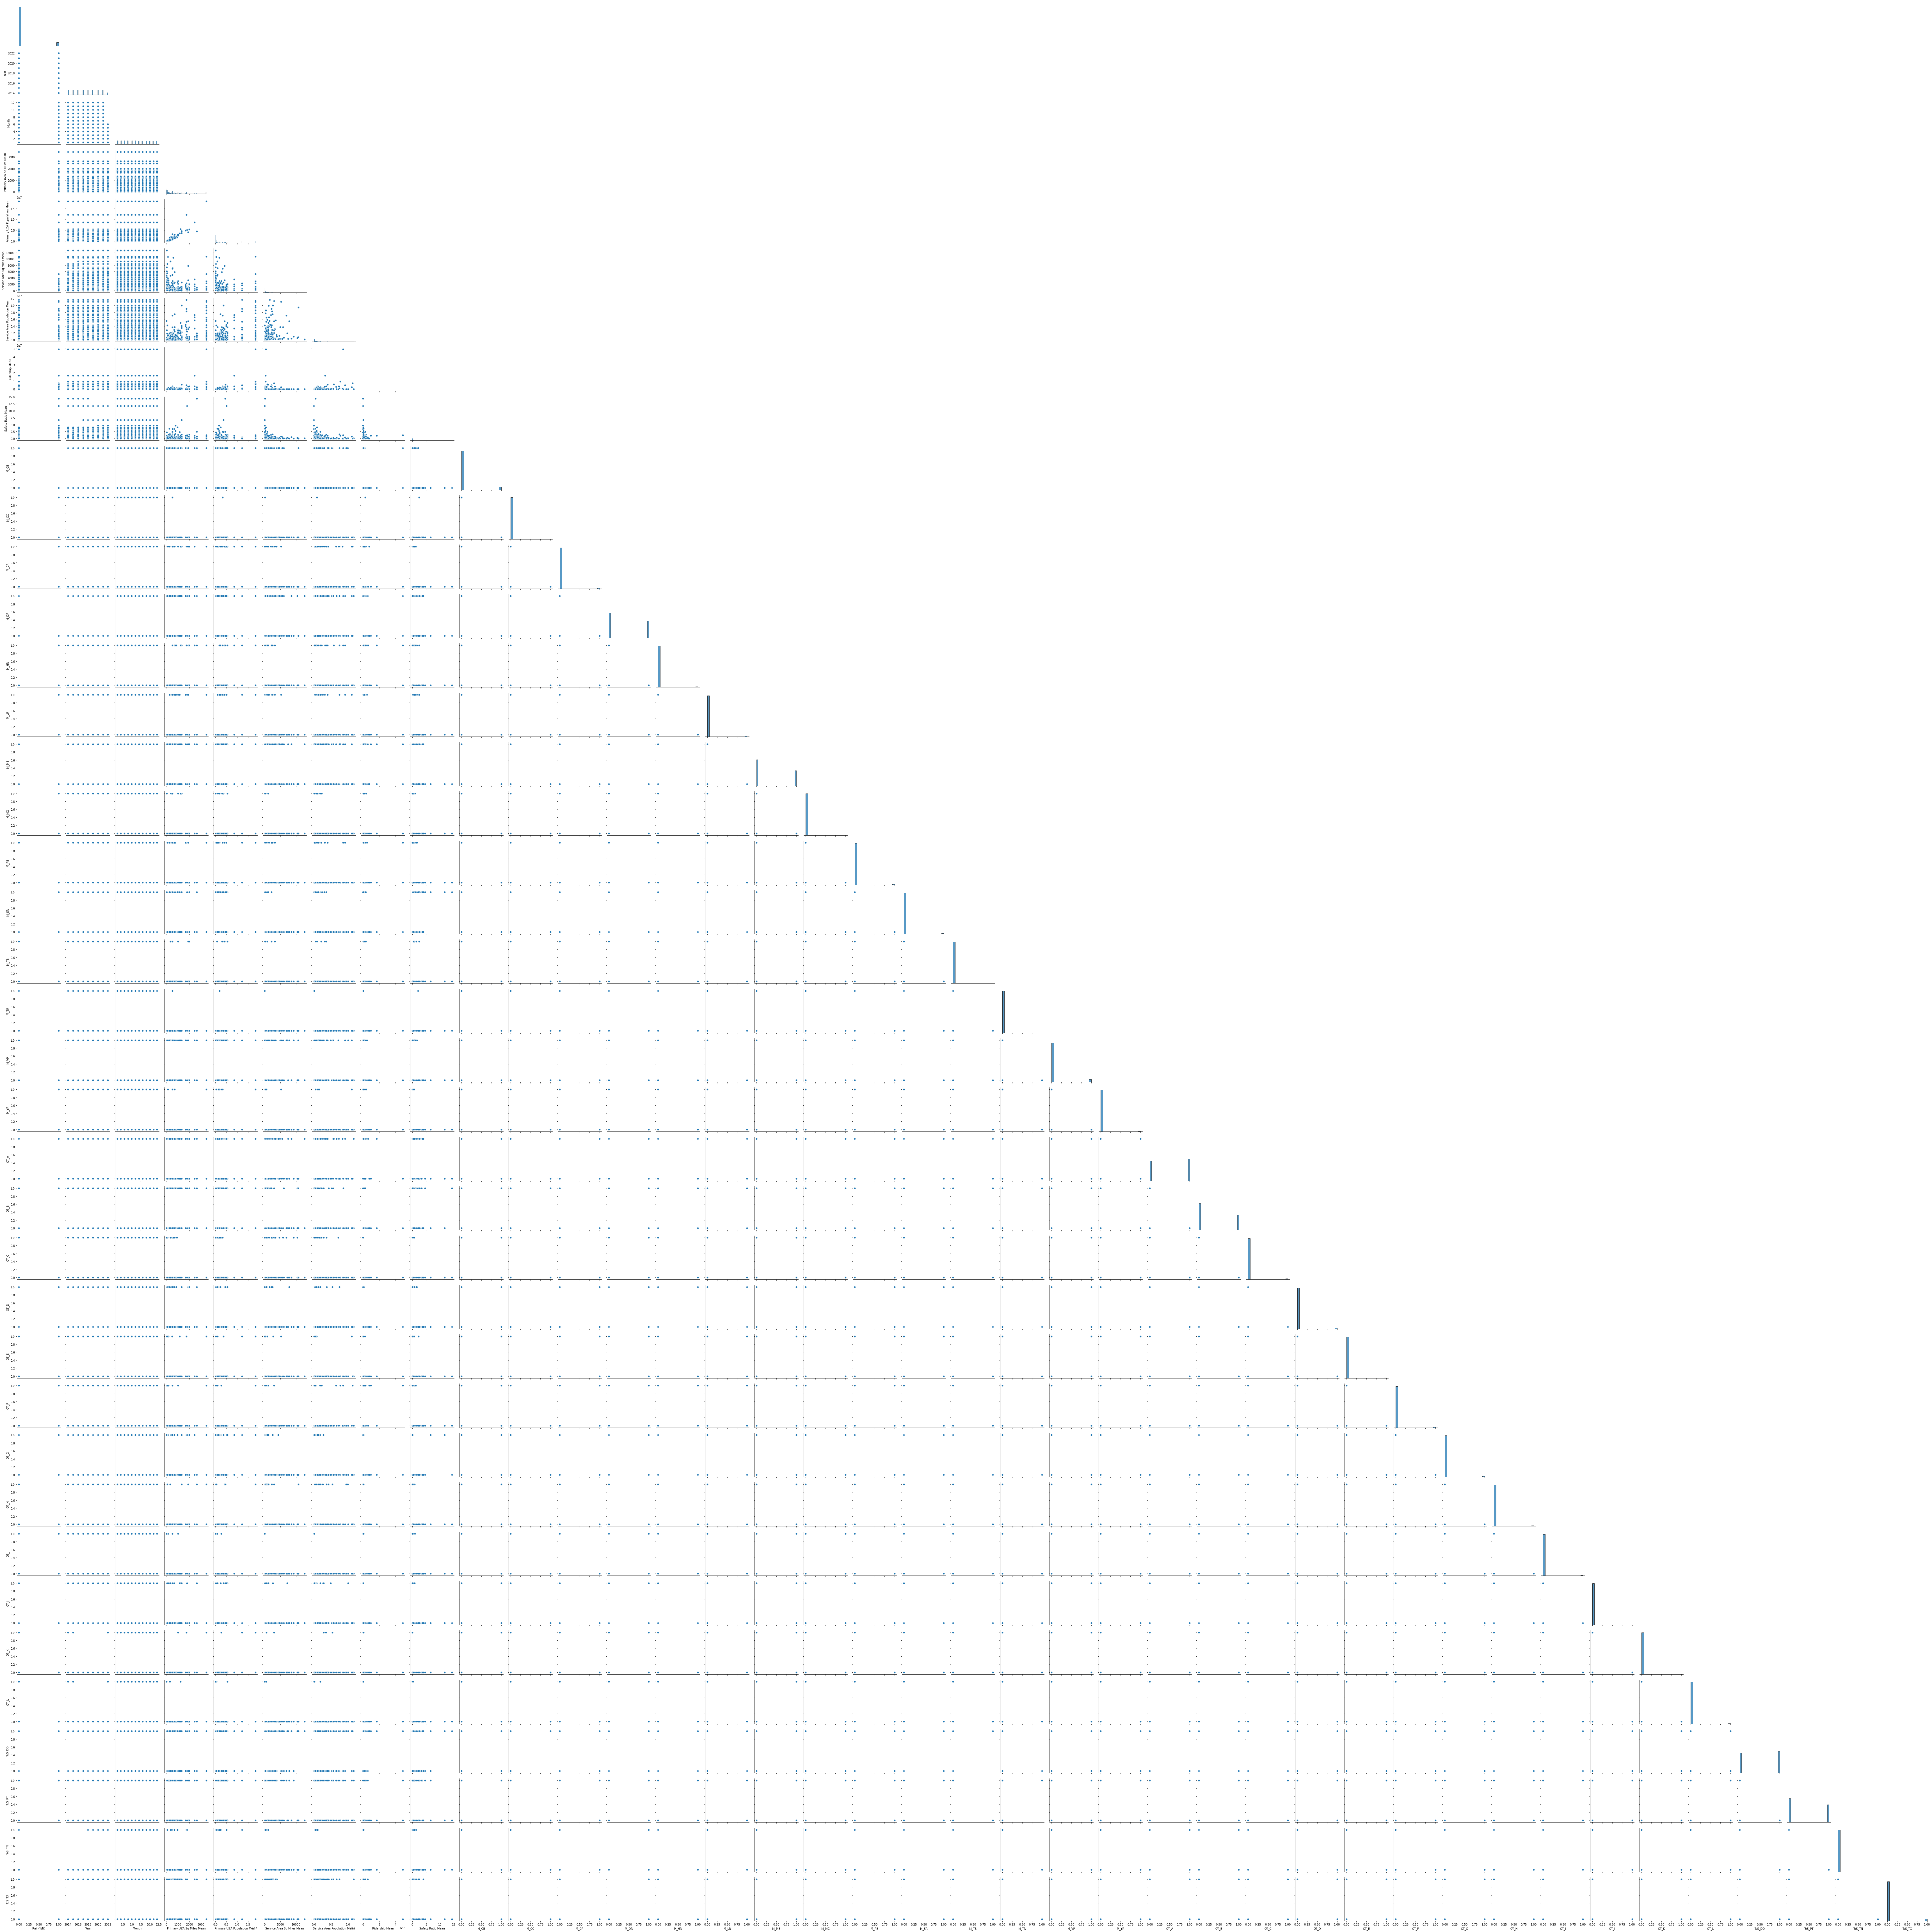

In [38]:
sns.pairplot(National_location, corner=True)

<AxesSubplot:>

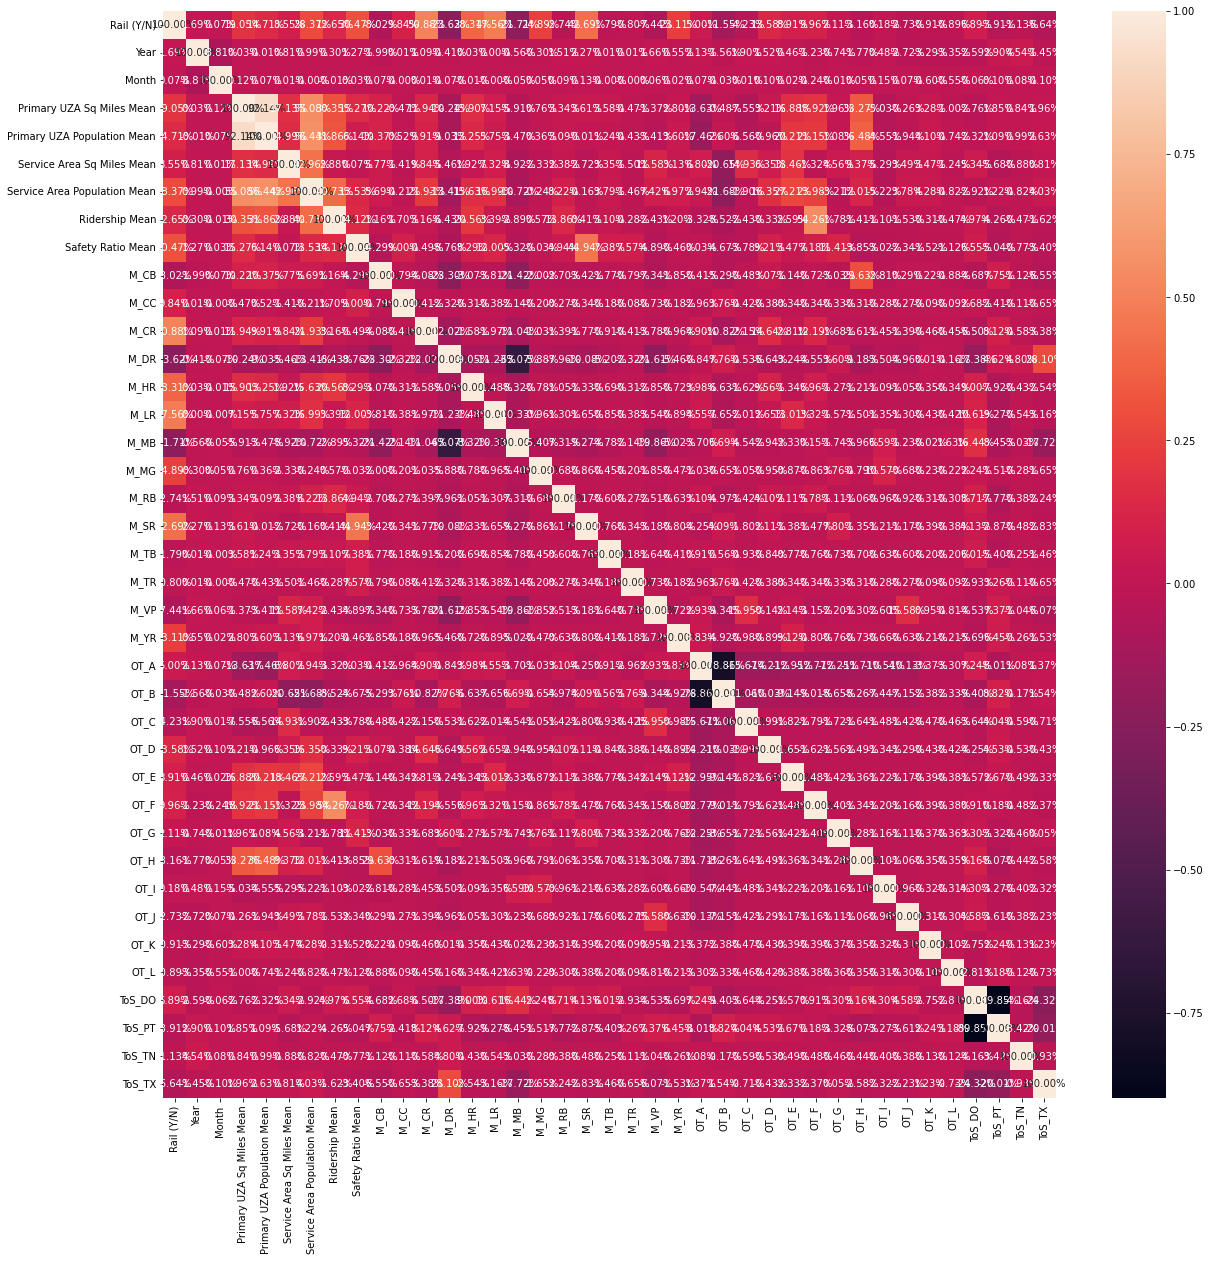

In [39]:
plt.subplots(figsize=(20,20))
sns.heatmap(National_location.corr(), annot=True, fmt='.2%')

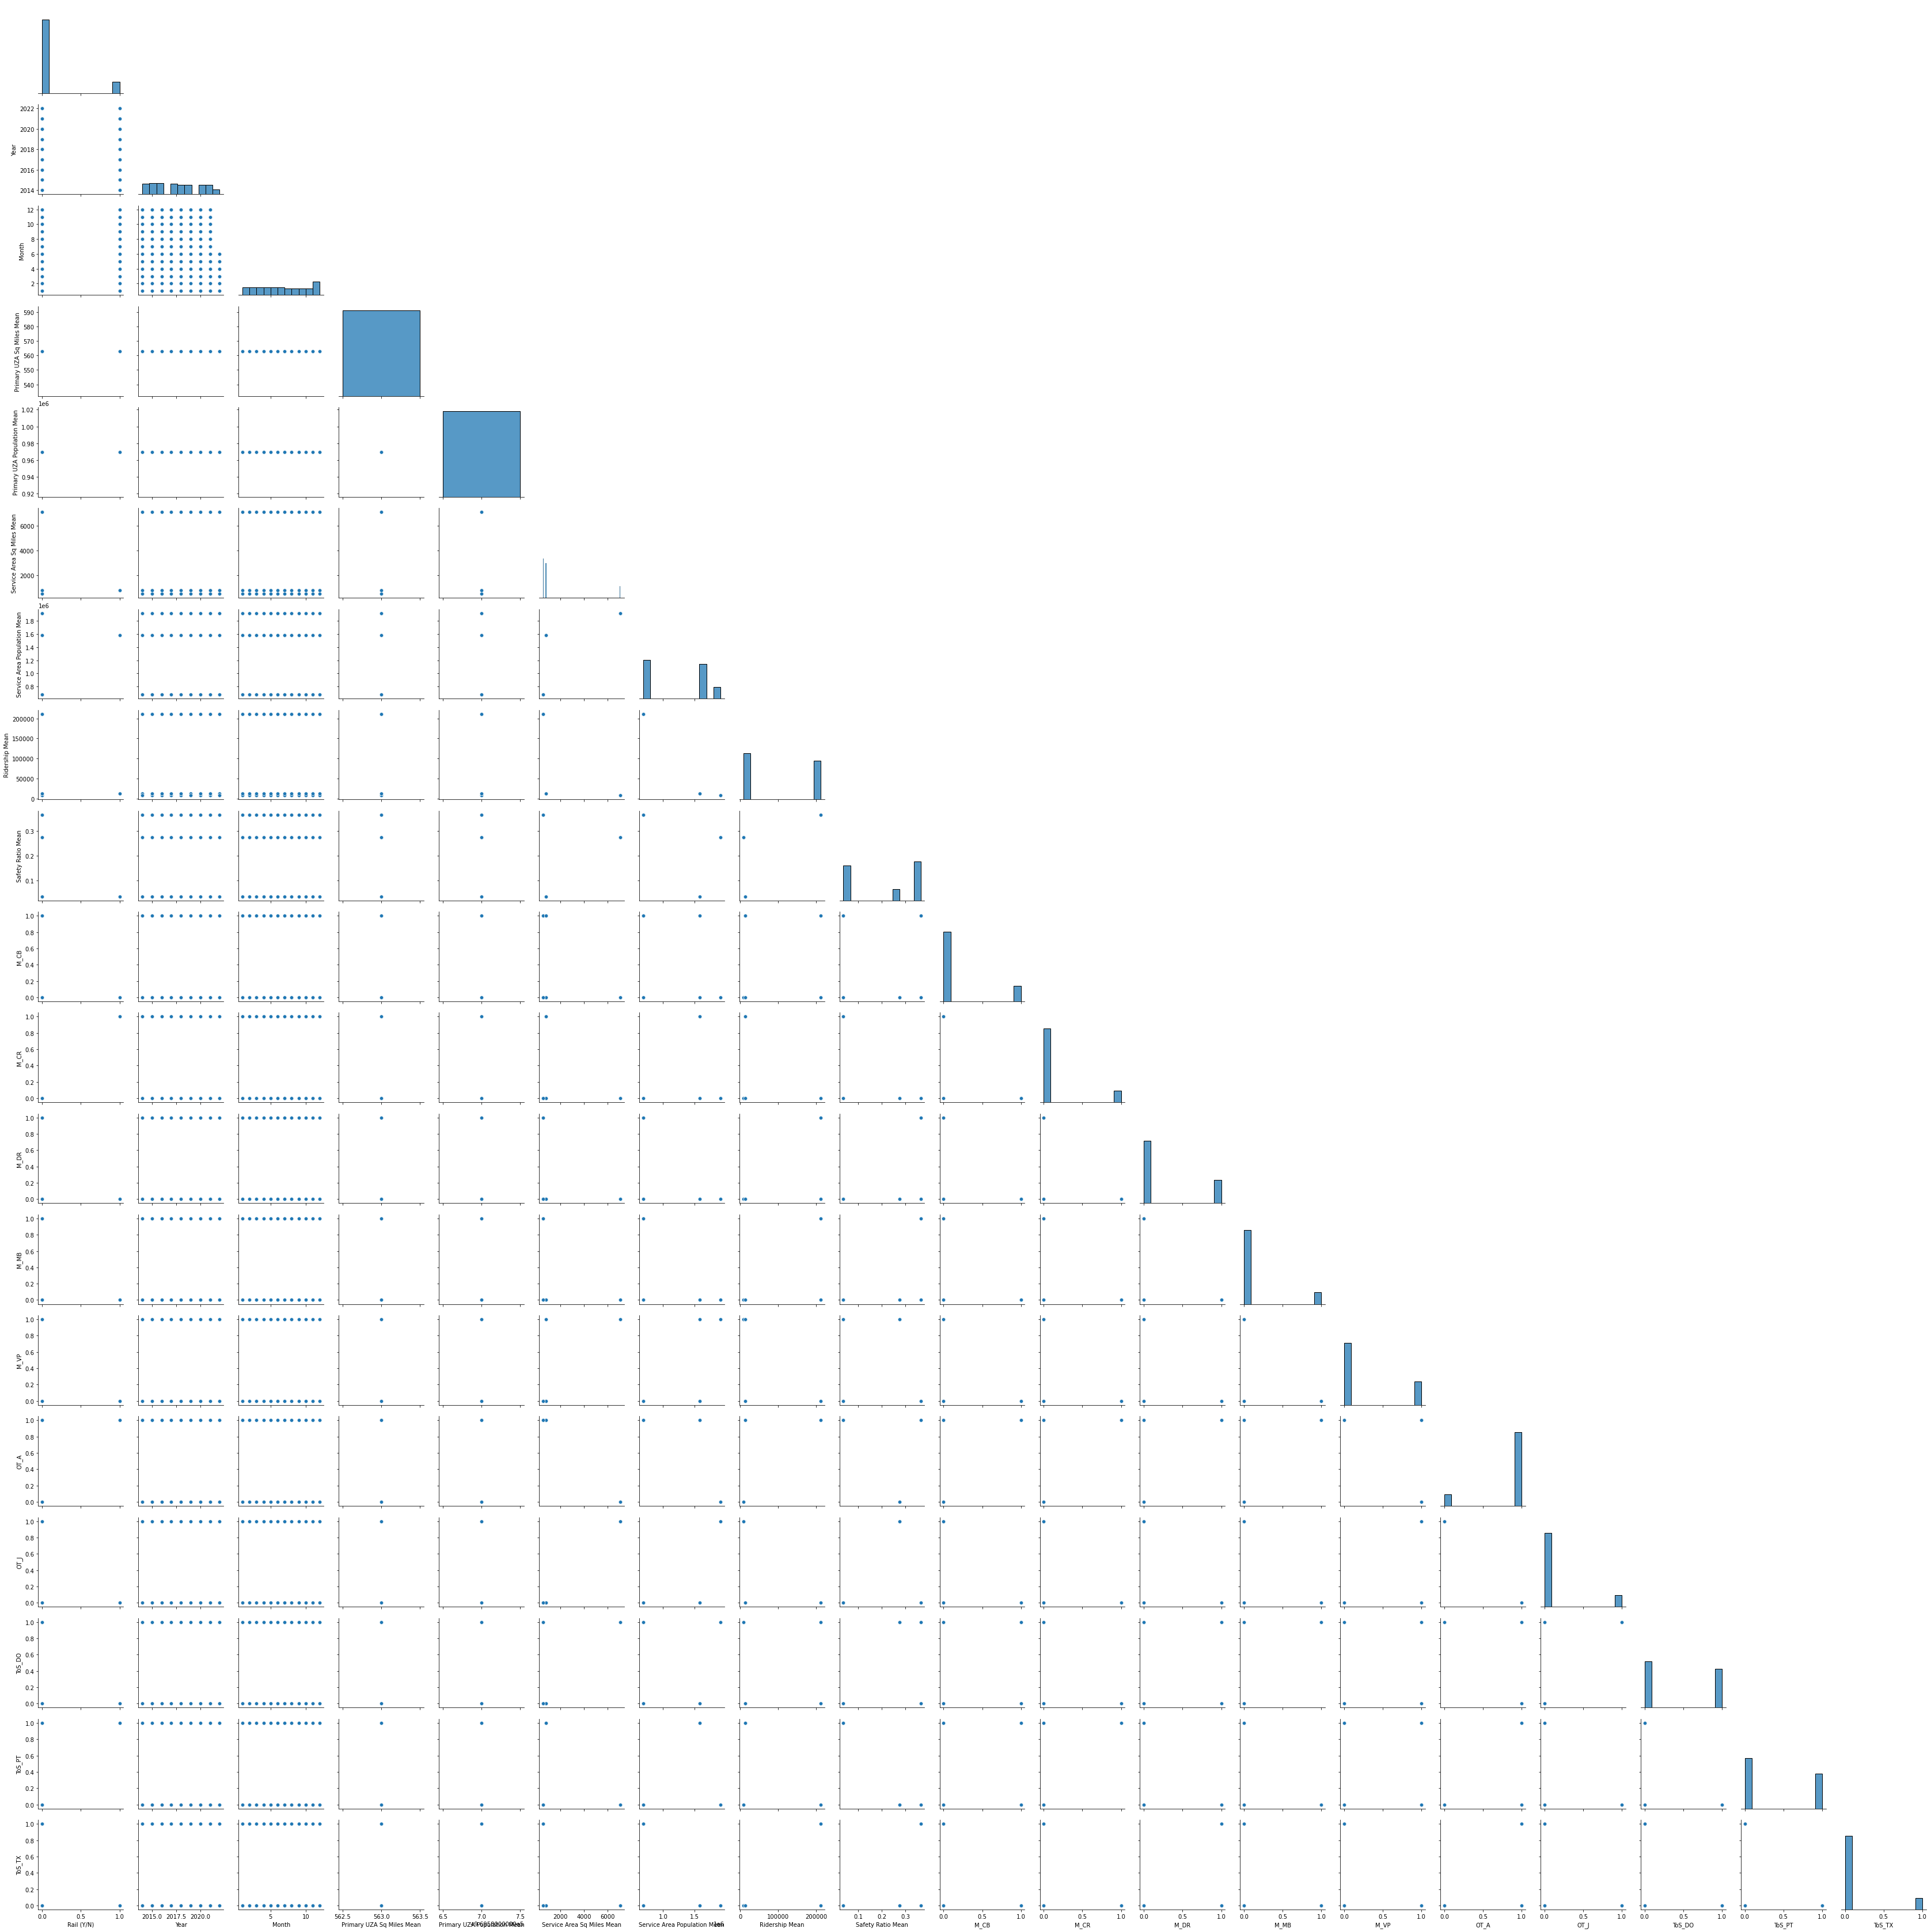

In [40]:
sns.pairplot(Nashville_location, corner=True)

<AxesSubplot:>

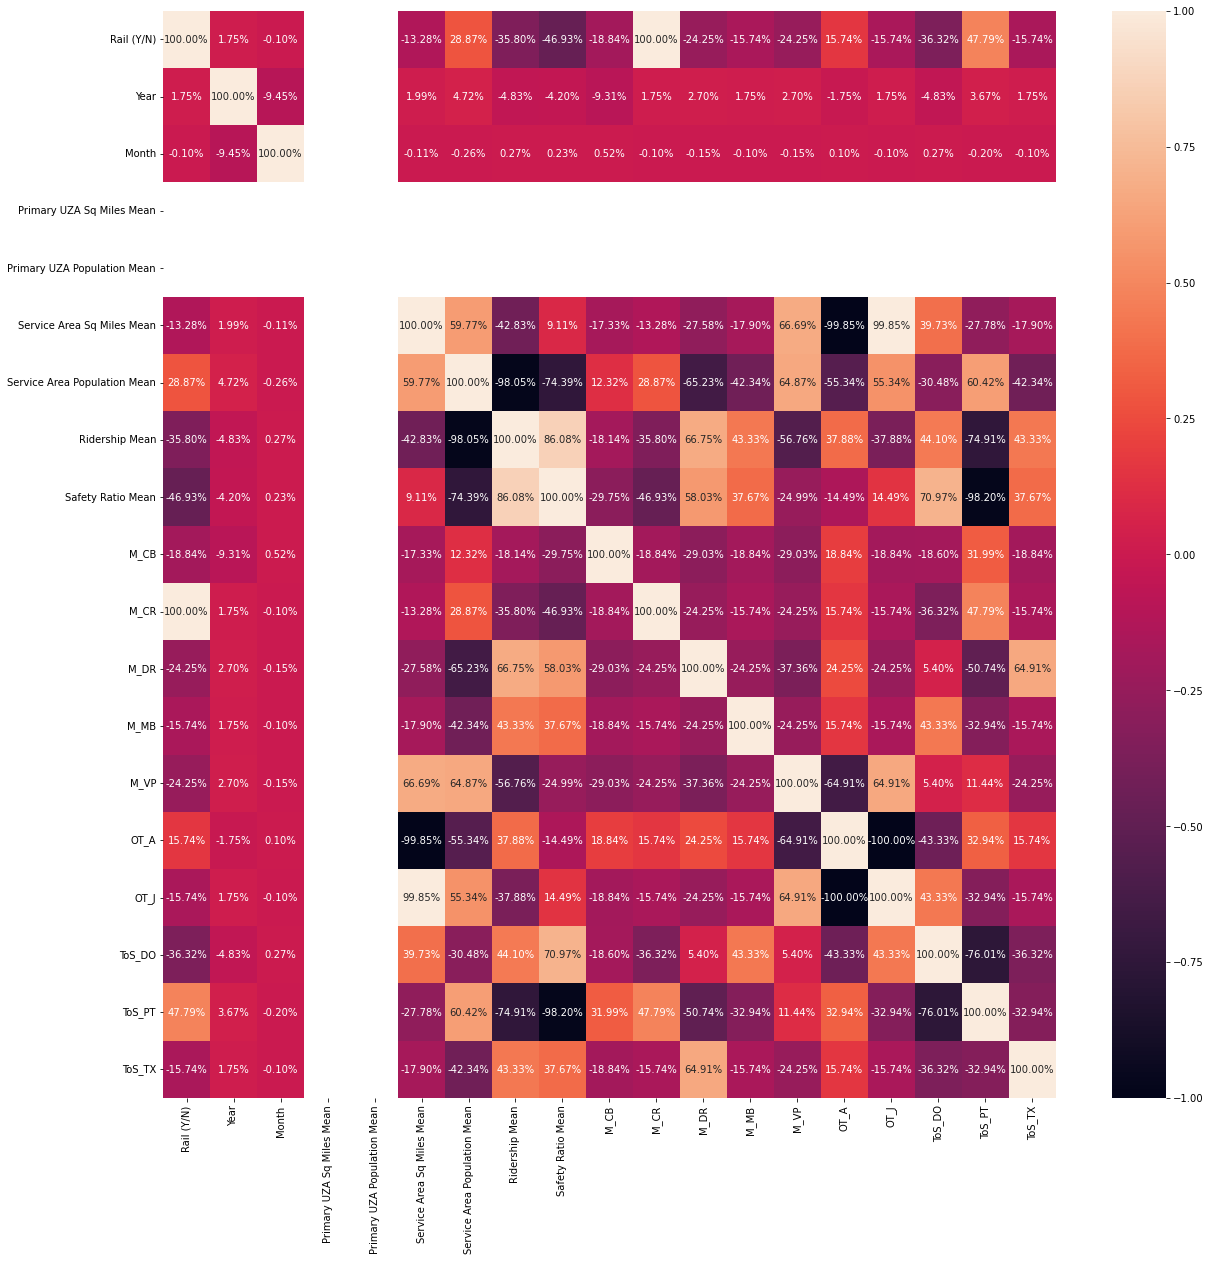

In [41]:
plt.subplots(figsize=(20,20))
sns.heatmap(Nashville_location.corr(), annot=True, fmt='.2%')

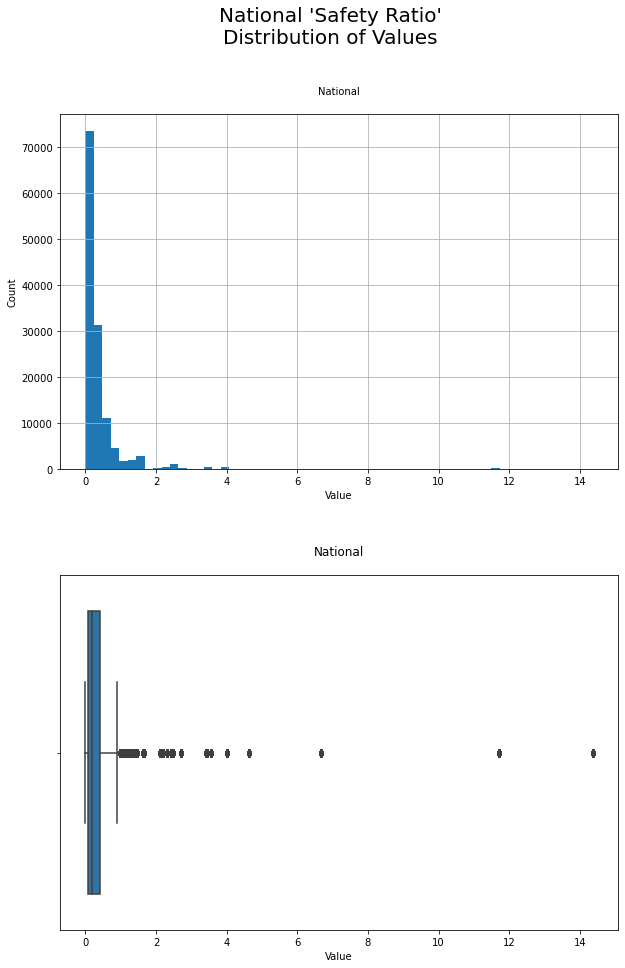

In [42]:
fig, ax =plt.subplots(2,1,figsize=(10,15), sharex=False)
fig.suptitle("National 'Safety Ratio'\nDistribution of Values", fontsize=20)


National_location.hist('Safety Ratio Mean', bins=60, ax=ax[0])
ax[0].set_title("National", fontsize=10, pad=20)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")

sns.boxplot(data=National_location, x='Safety Ratio Mean', ax=ax[1])
ax[1].set_title('National', fontsize=12, pad=20)
ax[1].set_xlabel("Value");


In [43]:
National_location['Safety Ratio Mean'].describe()

count    129752.000000
mean          0.353434
std           0.647763
min           0.000000
25%           0.072697
50%           0.189221
75%           0.407844
max          14.367081
Name: Safety Ratio Mean, dtype: float64

In [44]:
National_location['Safety Ratio Mean'].value_counts(normalize=True)

0.000000    0.077409
1.052435    0.006466
0.732478    0.006289
0.689492    0.006289
0.261577    0.006289
              ...   
0.208955    0.000185
0.484395    0.000185
0.490412    0.000116
0.552311    0.000100
0.420483    0.000092
Name: Safety Ratio Mean, Length: 490, dtype: float64

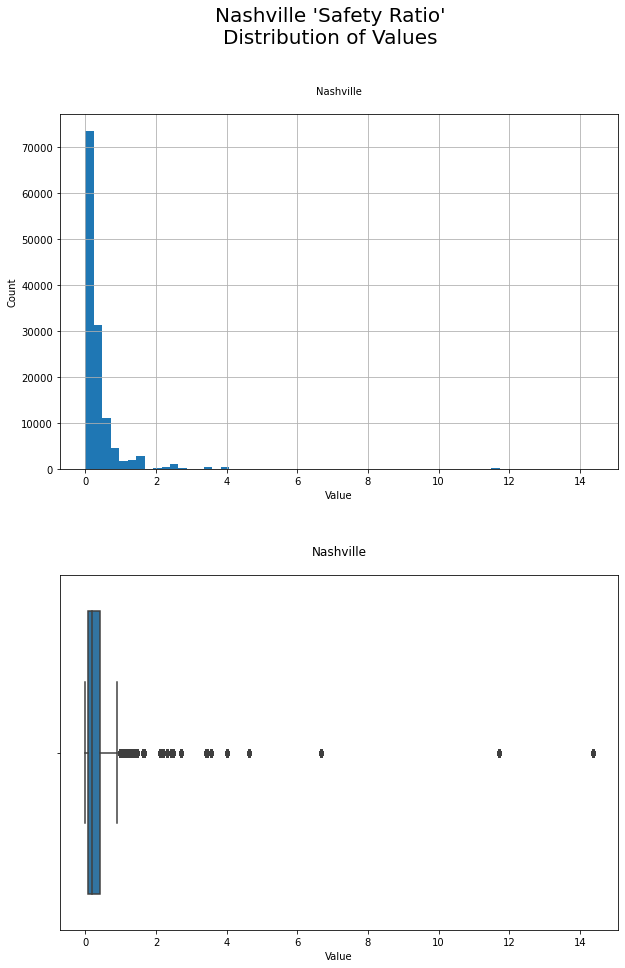

In [45]:
fig, ax =plt.subplots(2,1,figsize=(10,15), sharex=False)
fig.suptitle("Nashville 'Safety Ratio'\nDistribution of Values", fontsize=20)


National_location.hist('Safety Ratio Mean', bins=60, ax=ax[0])
ax[0].set_title("Nashville", fontsize=10, pad=20)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")

sns.boxplot(data=National_location, x='Safety Ratio Mean', ax=ax[1])
ax[1].set_title('Nashville', fontsize=12, pad=20)
ax[1].set_xlabel("Value");


In [46]:
Nashville_location['Safety Ratio Mean'].describe()

count    750.000000
mean       0.219111
std        0.154704
min        0.036242
25%        0.036242
50%        0.275577
75%        0.365889
max        0.365889
Name: Safety Ratio Mean, dtype: float64

In [47]:
Nashville_location['Safety Ratio Mean'].value_counts(normalize=True)

0.365889    0.456
0.036242    0.408
0.275577    0.136
Name: Safety Ratio Mean, dtype: float64

## 3.8 Model Trials
<a id= '3.8_Model_Trials'></a>
I will try three different regression models to see their usefulness.

### 3.8.1 Transforming the Target
<a id='3.8.1_Transforming_the_Target'></a>
Since the target ('Safety Ratio Mean') value is often zero in the National dataframe, I will transform it.  I will add 2 to each value and then take the log.

In [48]:
National_location['Safety Ratio Mean'] = National_location['Safety Ratio Mean'] + 2
National_location['Safety Ratio Mean'] = np.log(National_location['Safety Ratio Mean'])


In [49]:
National_location['Safety Ratio Mean'].describe()

count    129752.000000
mean          0.836027
std           0.176792
min           0.693147
25%           0.728851
50%           0.783546
75%           0.878732
max           2.795272
Name: Safety Ratio Mean, dtype: float64

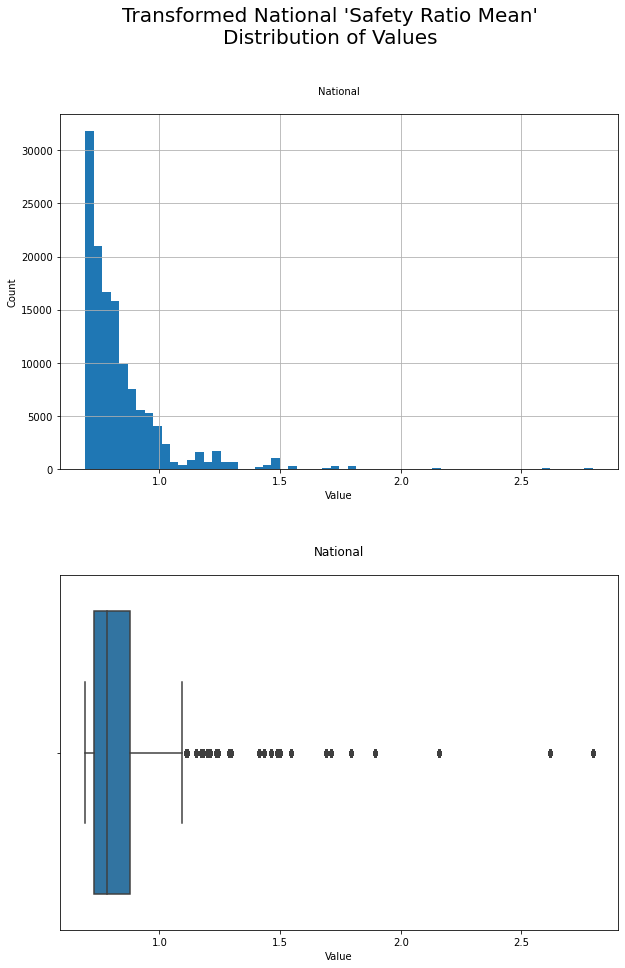

In [50]:
fig, ax =plt.subplots(2,1,figsize=(10, 15), sharex=False)
fig.suptitle("Transformed National 'Safety Ratio Mean'\nDistribution of Values", fontsize=20)


National_location.hist('Safety Ratio Mean', bins=60, ax=ax[0])
ax[0].set_title("National", fontsize=10, pad=20)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")

sns.boxplot(data=National_location, x='Safety Ratio Mean', ax=ax[1])
ax[1].set_title('National', fontsize=12, pad=20)
ax[1].set_xlabel("Value");

### 3.8.1 Train/Test Split
<a id= '3.8.1_Train_Test_Split'></a>

In [51]:
#Defining X and y from National_data

X_National = National_location.drop(['Safety Ratio Mean'], axis = 1)
y_National = National_location['Safety Ratio Mean']

In [52]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X_National, y_National, test_size=0.2, random_state=42)
#X_train.info()

### 3.8.2 Linear Regression
<a id= '3.8.2_Linear_Regression'></a>


In [53]:
Model_lr = LinearRegression()

In [54]:
Model_lr.fit(X_train, y_train)

LinearRegression()

In [55]:
y_pred_lr = Model_lr.predict(X_test)

In [56]:
y_pred_lr_undone = [np.exp(z) - 2 for z in y_pred_lr]

In [57]:
#Evaluation

R2_score_lr = Model_lr.score(X_train, y_train)
print("R Squared score:", R2_score_lr)

MAPE_lr = mean_absolute_percentage_error(y_test, y_pred_lr_undone)
print("MAPE:", MAPE_lr)

MAE_lr = mean_absolute_error(y_test, y_pred_lr_undone)
print("MAE:", MAE_lr)

MSE_lr = mean_squared_error(y_test, y_pred_lr_undone)
print("MSE:", MSE_lr)

R Squared score: 0.33873322249238724
MAPE: 0.6579299165127478
MAE: 0.5433359674373129
MSE: 0.32256020274274383


In [58]:
diff_lr = (y_test - y_pred_lr_undone)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_lr_series = pd.Series(y_pred_lr_undone, name='y_pred_lr_undone')
diff_lr_series = pd.Series(diff_lr, name='residual_lr')

y_pred_lr_series.index = y_test_series.index

data_lr=pd.concat([y_test_series, y_pred_lr_series, diff_lr_series], axis=1)



data_lr



,y_test,y_pred_lr_undone,residual_lr
11362,0.708749,0.222278,0.486470
102731,0.737399,0.255886,0.481512
115272,0.696475,0.348221,0.348254
5428,0.730629,0.329466,0.401164
30205,0.955248,0.228328,0.726919
...,...,...,...
20302,0.698339,0.183338,0.515001
19287,0.816292,0.234331,0.581961
106681,0.884181,0.255902,0.628279
108586,1.433057,0.230835,1.202221


In [59]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_lr = data_lr.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_lr_undone": ["min", "max", "median", "mean", mode, "std"],
        "residual_lr": ["min", "max", "median", "mean", mode, "std"],})
data_agg_lr

,y_test,y_pred_lr_undone,residual_lr
min,0.693147,-0.092067,-1.382599
max,2.795272,2.881350,1.473744
median,0.780662,0.246842,0.533678
mean,0.836316,0.318980,0.517336
<lambda>,0.693147,0.275992,0.429986
std,0.180320,0.290750,0.234363


### 3.8.3 Random Forest
<a id= '3.8.3_Random_Forest'></a>

In [60]:
Model_rf = RandomForestRegressor()

In [61]:
Model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [62]:
y_pred_rf = Model_rf.predict(X_test)

In [63]:
y_pred_rf_undone = [np.exp(z) - 2 for z in y_pred_rf]

In [64]:
#Evaluation

R2_score_rf = Model_rf.score(X_train, y_train)
print("R Squared score:", R2_score_rf)

MAPE_rf = mean_absolute_percentage_error(y_test, y_pred_rf_undone)
print("MAPE:", MAPE_rf)

MAE_rf = mean_absolute_error(y_test, y_pred_rf_undone)
print("MAE:", MAE_rf)

MSE_rf = mean_squared_error(y_test, y_pred_rf_undone)
print("MSE:", MSE_rf)

R Squared score: 0.9999999946640804
MAPE: 0.7125770706046113
MAE: 0.5778621808457781
MSE: 0.509447928441331


In [65]:
diff_rf = (y_test - y_pred_rf_undone)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_rf_series = pd.Series(y_pred_rf_undone, name='y_pred_rf_undone')
diff_rf_series = pd.Series(diff_rf, name='residual_rf')

y_pred_rf_series.index = y_test_series.index

data_rf=pd.concat([y_test_series, y_pred_rf_series, diff_rf_series], axis=1)
data_rf




,y_test,y_pred_rf_undone,residual_rf
11362,0.708749,0.031448,0.677301
102731,0.737399,0.090490,0.646908
115272,0.696475,0.006666,0.689808
5428,0.730629,0.076387,0.654242
30205,0.955248,0.599315,0.355933
...,...,...,...
20302,0.698339,0.010411,0.687928
19287,0.816292,0.262097,0.554195
106681,0.884181,0.421001,0.463180
108586,1.433057,2.191491,-0.758434


In [66]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_rf = data_rf.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_rf_undone": ["min", "max", "median", "mean", mode, "std"],
        "residual_rf": ["min", "max", "median", "mean", mode, "std"],})
data_agg_rf

,y_test,y_pred_rf_undone,residual_rf
min,0.693147,8.881784e-16,-11.571809
max,2.795272,1.436708e+01,0.693147
median,0.780662,1.829164e-01,0.597745
mean,0.836316,3.571665e-01,0.479149
<lambda>,0.693147,2.664535e-15,0.693147
std,0.180320,6.916295e-01,0.529032


### 3.8.4 KNN
<a id= '3.8.4_KNN'></a>

In [67]:
Model_knn = KNeighborsRegressor()

In [68]:
Model_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [69]:
y_pred_knn = Model_knn.predict(X_test)

In [70]:
y_pred_knn_undone = [np.exp(z) - 2 for z in y_pred_knn]

In [71]:
#Evaluation

R2_score_knn = Model_knn.score(X_train, y_train)
print("R Squared score:", R2_score_knn)

MAPE_knn = mean_absolute_percentage_error(y_test, y_pred_knn_undone)
print("MAPE:", MAPE_knn)

MAE_knn = mean_absolute_error(y_test, y_pred_knn_undone)
#MAE_knn_values = mean_absolute_error(y_test, y_pred_knn, multioutput='raw_values')
print("MAE:", MAE_knn)

MSE_knn = mean_squared_error(y_test, y_pred_knn_undone)
print("MSE:", MSE_knn)

R Squared score: 1.0
MAPE: 0.712577685827959
MAE: 0.5778626072861069
MSE: 0.5094485187080452


In [72]:
diff_knn = (y_test - y_pred_knn_undone)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_knn_series = pd.Series(y_pred_knn_undone, name='y_pred_knn_undone')
diff_knn_series = pd.Series(diff_knn, name='residual_knn')

y_pred_knn_series.index = y_test_series.index

data_knn=pd.concat([y_test_series, y_pred_knn_series, diff_knn_series], axis=1)
data_knn




,y_test,y_pred_knn_undone,residual_knn
11362,0.708749,0.031448,0.677301
102731,0.737399,0.090490,0.646908
115272,0.696475,0.006666,0.689808
5428,0.730629,0.076387,0.654242
30205,0.955248,0.599315,0.355933
...,...,...,...
20302,0.698339,0.010411,0.687928
19287,0.816292,0.262097,0.554195
106681,0.884181,0.421001,0.463180
108586,1.433057,2.191491,-0.758434


In [73]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_knn = data_knn.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_knn_undone": ["min", "max", "median", "mean", mode, "std"],
        "residual_knn": ["min", "max", "median", "mean", mode, "std"],})
data_agg_knn

,y_test,y_pred_knn_undone,residual_knn
min,0.693147,0.000000,-11.571809
max,2.795272,14.367081,0.693147
median,0.780662,0.182916,0.597745
mean,0.836316,0.357166,0.479150
<lambda>,0.693147,0.000000,0.693147
std,0.180320,0.691630,0.529032


### 3.8.5 Comparing the Models' Performance
<a id='3.8.5_Comparing_the_Models_Performance'></a>


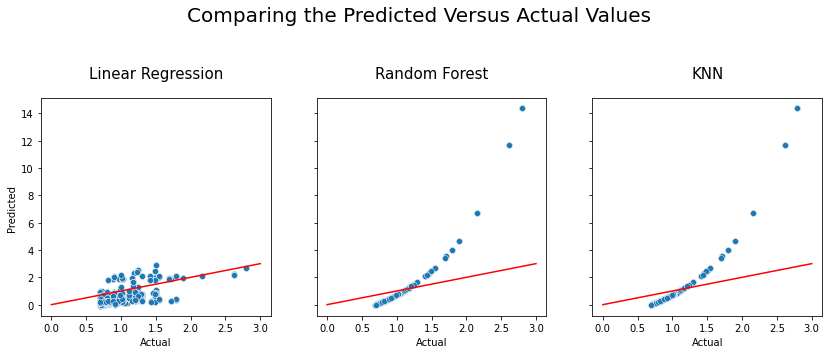

In [74]:
#Comparing the Predicted Versus Actual Values

fig, ax =plt.subplots(1,3,figsize=(14,4), sharey=True, sharex=True)
fig.suptitle("Comparing the Predicted Versus Actual Values", fontsize=20, y=1.2)


sns.scatterplot(x=y_test, y=y_pred_lr_undone, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
ax[0].plot([x for x in range (0,4)],[x for x in range (0,4)], color='red')

sns.scatterplot(x=y_test, y=y_pred_rf_undone, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_xlabel("Actual")
ax[1].set_ylabel("Predicted")
ax[1].plot([x for x in range (0,4)],[x for x in range (0,4)], color='red')

sns.scatterplot(x=y_test, y=y_pred_knn_undone, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_xlabel("Actual")
ax[2].set_ylabel("Predicted")
ax[2].plot([x for x in range (0,4)],[x for x in range (0,4)], color='red');



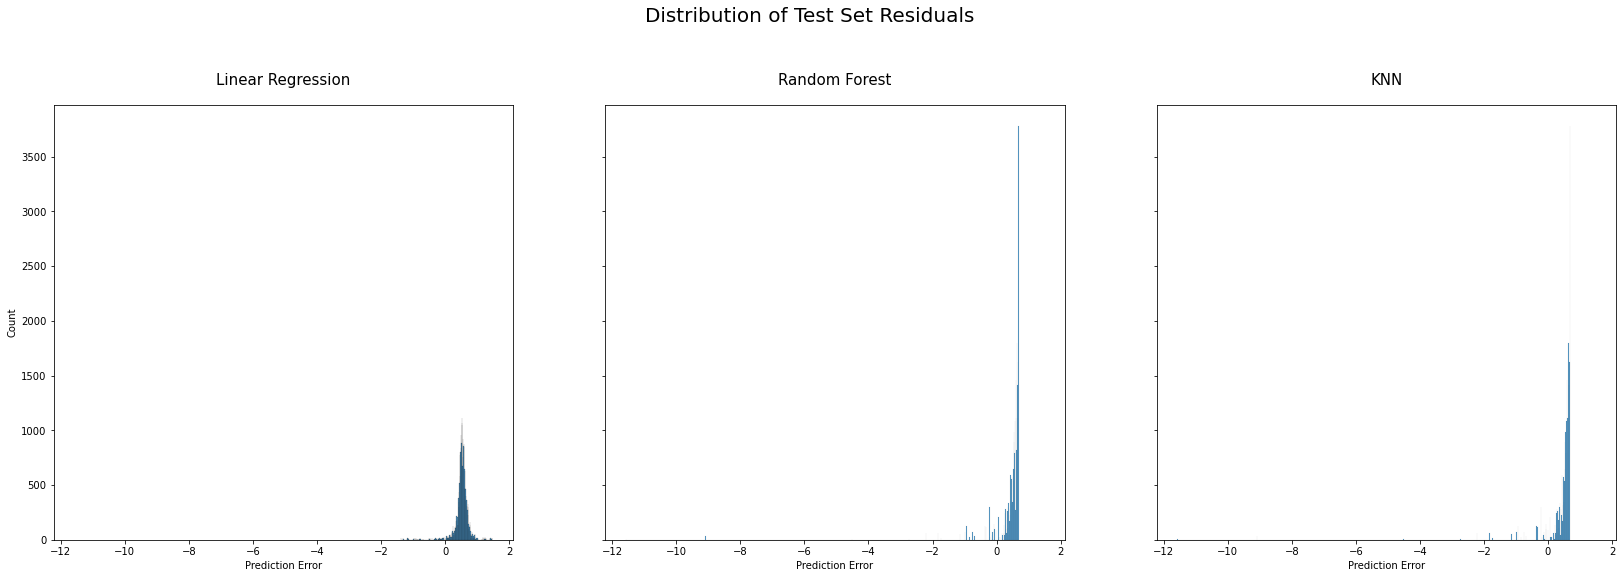

In [75]:
#Comparing the Residuals

fig, ax =plt.subplots(1,3,figsize=(28,8), sharey=True, sharex=True)
fig.suptitle("Distribution of Test Set Residuals", fontsize=20, y=1.05)


sns.histplot(diff_lr, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_xlabel("Prediction Error")
ax[0].set_ylabel("Count")

sns.histplot(diff_rf, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_xlabel("Prediction Error")
ax[1].set_ylabel("Count")

sns.histplot(diff_knn, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_xlabel("Prediction Error")
ax[2].set_ylabel("Count");


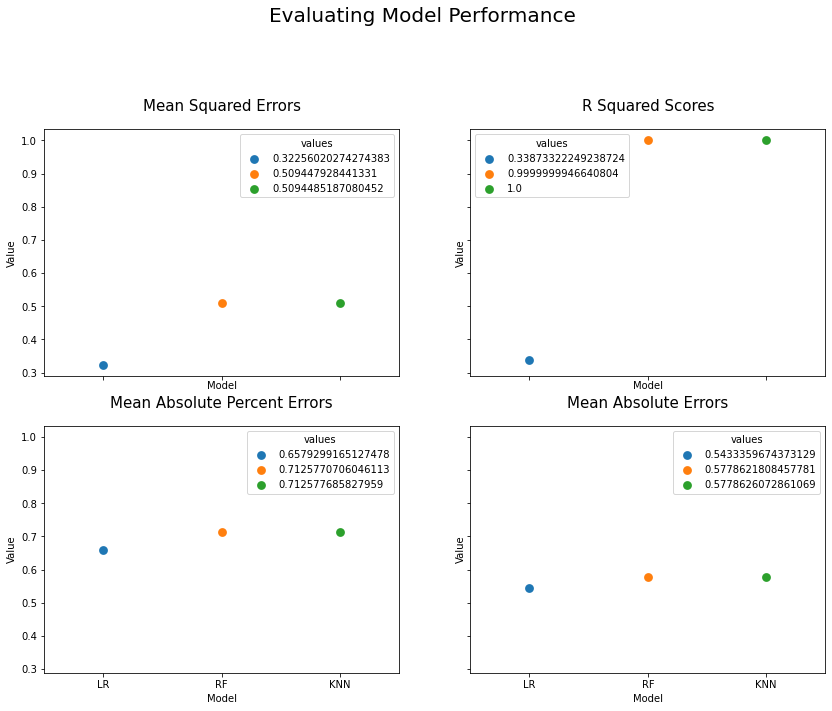

In [76]:
#Comparing the Mean Squared Error

MSEs = pd.Series([MSE_lr, MSE_rf, MSE_knn], name='values')
R2s = pd.Series([R2_score_lr, R2_score_rf, R2_score_knn], name='values')
MAPEs = pd.Series([MAPE_lr, MAPE_rf, MAPE_knn], name='values')
MAEs = pd.Series([MAE_lr, MAE_rf, MAE_knn], name='values')
labels = pd.Series(['LR','RF','KNN'], name='labels')

fig, ax =plt.subplots(2,2,figsize=(14,10), sharex=True, sharey=True)
fig.suptitle("Evaluating Model Performance", fontsize=20, y=1.05)

sns.pointplot(data=pd.concat([MSEs, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[0,0], hue='values')
ax[0,0].set_title("Mean Squared Errors", fontsize=15, y=1.05)
ax[0,0].set_xlabel("Model", fontsize=10)
ax[0,0].set_ylabel("Value", fontsize=10, x=1.05)

sns.pointplot(data=pd.concat([R2s, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[0,1], hue='values')
ax[0,1].set_title("R Squared Scores", fontsize=15, y=1.05)
ax[0,1].set_xlabel("Model", fontsize=10)
ax[0,1].set_ylabel("Value", fontsize=10, x=1.05);

sns.pointplot(data=pd.concat([MAPEs, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[1,0], hue='values')
ax[1,0].set_title("Mean Absolute Percent Errors", fontsize=15, y=1.05)
ax[1,0].set_xlabel("Model", fontsize=10)
ax[1,0].set_ylabel("Value", fontsize=10, x=1.05)

sns.pointplot(data=pd.concat([MAEs, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[1,1], hue='values')
ax[1,1].set_title("Mean Absolute Errors", fontsize=15, y=1.05)
ax[1,1].set_xlabel("Model", fontsize=10)
ax[1,1].set_ylabel("Value", fontsize=10, x=1.05);

None of the regression models is very successful in predicting the target values.

## 3.9 Save the Data
<a id='3.9_Save_the_Data'></a>

In [77]:
National_data.to_csv("National_data_post_preprocessing.csv", index=False)
Nashville_data.to_csv("Nashville_data_post_preprocessing.csv", index=False)
National_location.to_csv("National_location.csv", index=False)
Nashville_location.to_csv("Nashville_location.csv", index=False)

## 3.10 Summary
<a id='3.10_Summary'></a>

In this notebook, I defined safety in order to establish a clear single column for the dependant variable.  I dropped columns which were redundant for unneeded and then one hot encoded the categorical columns.  

I transformed the target by adding 2 and then taking the log because there were so many occasions where the target value in the National dataframe was zero.  I focused on time-independant linear regression models but found none were useful in predicting the target values.

In the next notebook, I will pivot to time series analysis in an effort to gain insight into how the features and the target vary with respect to time.